In [ ]:
## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

### Download data

In [ ]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

In [ ]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [ ]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

In [ ]:
! pip install -e git+git://github.com/fmfn/BayesianOptimization#egg=bayes_opt

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import numpy
from itertools import product

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

features = list(set(data.columns) - {'event_id', 'target'})
print (features)

high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

['jet3_pt', 'jet3_eta', 'm_jjj', 'mem_phi', 'jet1_pt', 'jet4_phi', 'jet1_phi', 'jet2_eta', 'jet3_btag', 'm_jlv', 'm_wbb', 'jet4_pt', 'jet4_btag', 'jet2_pt', 'jet1_btag', 'm_jj', 'm_wwbb', 'jet2_phi', 'lepton_phi', 'm_bb', 'm_lv', 'jet4_eta', 'jet2_btag', 'lepton_pt', 'mem_pt', 'lepton_eta', 'jet3_phi', 'jet1_eta']


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


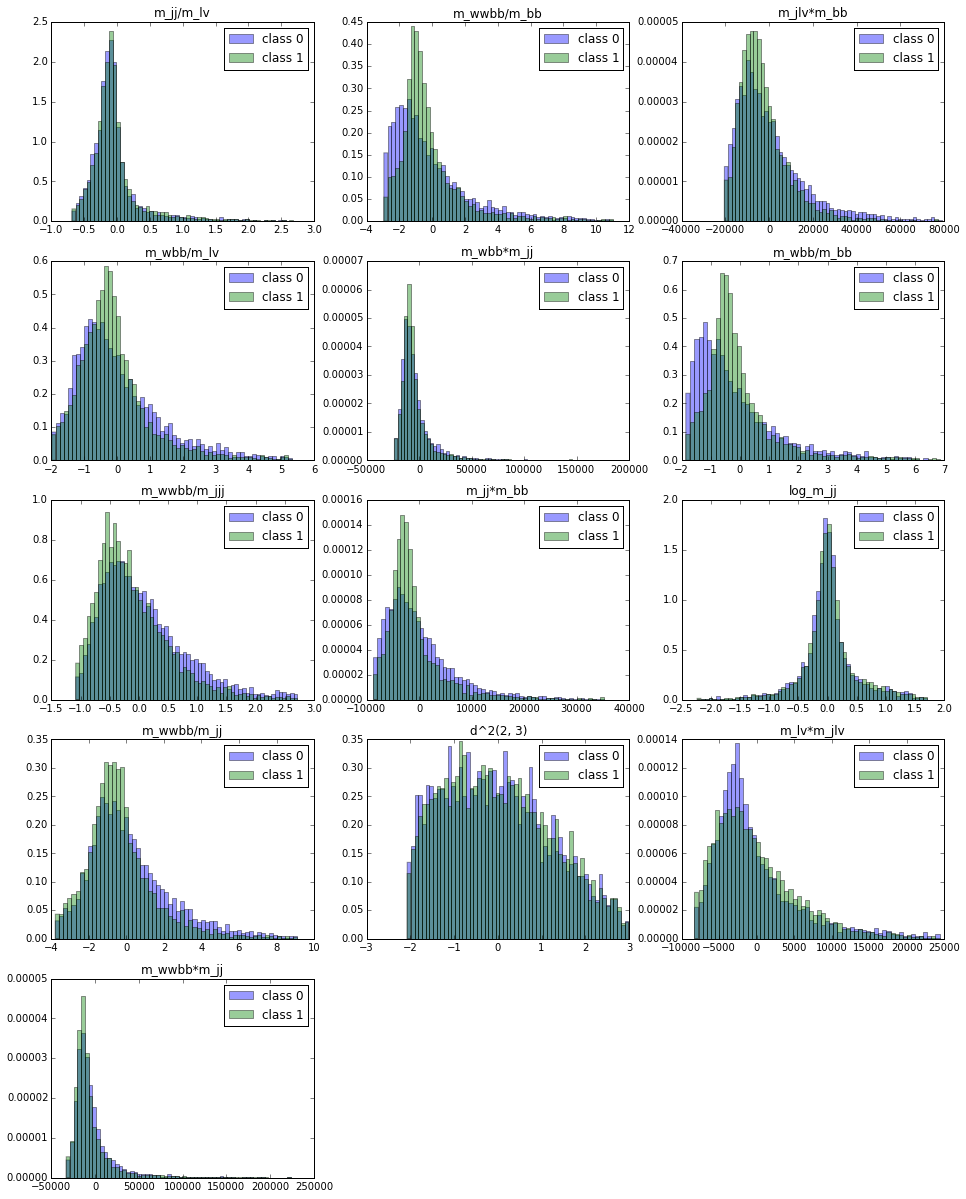

In [111]:
page = 4
plotdata = preprocess(data)
plotfeatures = list(set(plotdata.columns) - {'event_id', 'target'} - set(features))
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(plotfeatures[18*page:18*page+18]):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(plotdata[feature], [1, 99])
    plt.hist(plotdata.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(plotdata.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

In [112]:
def limitPerc(X, l,h):
    Z = X.copy()
    for feature in Z:
        upperlim = np.percentile(Z[feature],h)
        Z[feature][ Z[feature] > upperlim ] = upperlim
        lowerlim = np.percentile(Z[feature],l)
        Z[feature][ Z[feature] < lowerlim ] = lowerlim
    return Z
        
def centralize(X):
    Z = X.copy()
    for feature in Z:
        Z[feature] -= np.mean(Z[feature])
    return Z

def rescale(X):
    Z = X.copy()
    for f in Z:
        Z[f] /= max(X[f]) - min(X[f])
    return Z

def logarize(X):
    Z = X.copy()
    Z = np.log(X - min(X) + 1)
    return Z

def angleBetween(phi1, eta1,phi2,eta2):
    return np.arccos(np.cos(eta1)*np.cos(eta2) + np.sin(eta1)*np.sin(eta2)*np.cos(phi1-phi2))

def getTheta(eta):
    return 2*np.arctan(np.exp(-eta))

def preprocess(X):
    Z = X.copy()
    Z = limitPerc(Z,0.5,99.5)
    Z['log_m_lv'] = np.log(Z['m_lv'] - min(Z['m_lv']) + 1)
    Z['log_m_jj'] = np.log(Z['m_jj'] - min(Z['m_jj']) + 1)
    Z['log_m_jjj'] = np.log(Z['m_jjj'] - min(Z['m_jjj']) + 1)
    Z['log_m_wwbb'] = logarize(Z['m_wwbb'])
    Z['sqrt_jet1_pt'] = np.sqrt(Z['jet1_pt'] - min(Z['jet1_pt'])+0)
    Z['sqrt_jet2_pt'] = np.sqrt(Z['jet2_pt'] - min(Z['jet2_pt'])+0)
    Z['sqrt_jet3_pt'] = np.sqrt(Z['jet3_pt'] - min(Z['jet3_pt'])+0)
    Z['sqrt_jet4_pt'] = np.sqrt(Z['jet4_pt'] - min(Z['jet4_pt'])+0)
    
    for m1 in high_level_features:
        for m2 in high_level_features:
            if(m1 != m2):
                Z[m1+'/'+m2] = Z[m1]/Z[m2]
                #asfasdfadsfsadf=1

    for m1 in high_level_features:
        for m2 in high_level_features:
            if(m1 > m2):
                Z[m1+'*'+m2] = Z[m1]*Z[m2]
                #asdfasfadsf=1
                
    phis = ['jet1_phi','jet2_phi','jet3_phi','jet4_phi']
    etas = ['jet1_eta','jet2_eta','jet3_eta','jet4_eta']
    angles = []
    
    for j1 in range(len(phis)):
        for j2 in range(j1+1,len(phis)):
            angl = angleBetween(Z[phis[j1]],getTheta(Z[etas[j1]]),Z[phis[j2]],getTheta(Z[etas[j2]]))
            Z['angle'+str(j1)+str(j2)] = angl
            angles.append(angl)
            
    Z['max/minangle'] = np.amax(angles, axis=0) / np.amin(angles, axis=0) 
    Z['maxangle'] = np.amax(angles, axis=0)
    
    
    
    jet_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(range(1,5), range(1,5)))))

    distances = []
    for jet_pair in jet_pairs:
        jet1, jet2 = jet_pair
        distances.append(np.sqrt(
           (Z["jet%d_eta" % jet1] - Z["jet%d_eta" % jet2])**2 +
           (Z["jet%d_phi" % jet1] - Z["jet%d_phi" % jet2])**2))
    distances_df = pandas.concat(distances, axis=1)
    distances_df.columns=list(map(lambda pair: "d^2(%d, %d)" % tuple(pair), jet_pairs))
    Z = pandas.concat(
        [Z, distances_df], axis=1)
            
    
           
    
    #Z['sin_jet1_phi'] = np.cos(Z['jet1_phi'] )
    #Z['sin_jet2_phi'] = np.cos(Z['jet2_phi'] )
    #Z['sin_jet3_phi'] = np.cos(Z['jet3_phi'] )
    #Z['sin_jet4_phi'] = np.cos(Z['jet4_phi'] )
    #Z['sin_mem_phi'] = np.cos(Z['mem_phi'] )
    #Z['sin_lepton_phi'] = np.sin(Z['lepton_phi'] )
    #Z['jet12_phi'] = Z['jet1_phi'] / Z['jet2_phi']
    #Z['jet13_phi'] = Z['jet1_phi'] / Z['jet3_phi']
    #Z['jet14_phi'] = Z['jet1_phi'] / Z['jet4_phi']
    #Z['jet23_phi'] = Z['jet2_phi'] / Z['jet3_phi']
    #Z['jet24_phi'] = Z['jet2_phi'] / Z['jet4_phi']
    #Z['jet34_phi'] = Z['jet3_phi'] / Z['jet4_phi']
    #del(Z['m_lv'])
    #del(Z['m_wwbb'])
    #del(Z['jet1_pt'])
    #del(Z['jet2_pt'])
    #del(Z['jet3_pt'])
    #del(Z['jet4_pt'])
    return centralize(Z)

preprocess(data[0:1]).shape

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1, 115)

In [ ]:
feature='sqrt_jet1_pt'
# add sub plot on our figure
# define range for histograms by cutting 1% of data from both ends
min_value, max_value = numpy.percentile(Z[feature], [1, 99])
plt.hist(Z.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
         label='class 0', **hist_params)
plt.hist(Z.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
         label='class 1', **hist_params)
plt.legend(loc='best')
plt.title(feature)

### Plot histograms for each high-level feature

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [7]:
training_data, validation_data = train_test_split(data, random_state=17, train_size=0.80)

In [ ]:
N = 1
results_2 = np.zeros(N)
for i in xrange(N):
    from sklearn.decomposition import PCA
    X = training_data[features]
    pca = PCA(n_components=70)
    pca.fit(preprocess(X))
    #print(pca.explained_variance_ratio_) 

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from rep.estimators import XGBoostClassifier
    classif =  RandomForestClassifier(n_estimators=100, max_depth=10, max_features=50, n_jobs=-1)
    classif.fit(pca.transform(preprocess(training_data[features])).astype(np.float64), training_data.target)

    # predict validation sample (probability for each event)
    proba = classif.predict_proba(pca.transform(preprocess(validation_data[features])).astype(np.float64))

    # take probability to be 1 class to compute ROC AUC
    results_2[i] = roc_auc_score(validation_data.target, proba[:, 1])
    print (results_2[i])
print (sorted(results_2))

In [18]:
N = 10
results_2 = np.zeros(N)
for i in xrange(N):
    from sklearn.decomposition import PCA
    X = training_data[features]
    pca = PCA(n_components=70)
    pca.fit(preprocess(X))
    #print(pca.explained_variance_ratio_) 

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from rep.estimators import XGBoostClassifier
    #classif = XGBoostClassifier()
    classif =  RandomForestClassifier(n_estimators=100, max_depth=10, max_features=50, n_jobs=-1)
    classif.fit(pca.transform(preprocess(training_data[features])).astype(np.float64), training_data.target)

    # predict validation sample (probability for each event)
    proba = classif.predict_proba(pca.transform(preprocess(validation_data[features])).astype(np.float64))

    # take probability to be 1 class to compute ROC AUC
    results_2[i] = roc_auc_score(validation_data.target, proba[:, 1])
    print (results_2[i])
print (sorted(results_2))

0.767325075326
0.763440373752
0.765936676549
0.765662213938
0.766528832147
0.766082453394
0.768209789971
0.765919585471
0.767202421705
0.765524479954
[0.76344037375172291, 0.76552447995367312, 0.76566221393807599, 0.76591958547097494, 0.7659366765493314, 0.76608245339413739, 0.7665288321465088, 0.76720242170526731, 0.76732507532641447, 0.76820978997075418]


In [ ]:
pca = PCA(n_components=6)
pca.fit(preprocess(X))
print(pca.explained_variance_ratio_) 

In [62]:
from __future__ import print_function
from __future__ import division

datalimit = 1000

from bayes_opt import BayesianOptimization
def rfccv( subsample, max_depth,eta):
    return cross_val_score(XGBoostClassifier(eta=eta,subsample=subsample,
            n_estimators=100,
            max_depth=int(max_depth),
            random_state=2),
                           pca.transform(preprocess(data[features][0:datalimit])).astype(np.float64), data.target[0:datalimit], scoring="roc_auc",
                           cv=4, n_jobs=1).mean()

rfcBO = BayesianOptimization(rfccv, {'subsample': (0, 1),
                                     'max_depth': (1, 30),
                                     'eta': (0, 1)
                                    })
rfcBO.maximize(init_points=10, n_iter=50)
print('-'*53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
---------------------------------------------------------------------
 Step |   Time |      Value |       eta |   max_depth |   subsample | 
    1 | 00m00s |    0.59505 |    0.6199 |      4.6578 |      0.0958 | 
    2 | 00m02s |    0.71623 |    0.2512 |     27.6212 |      0.8456 | 
    3 | 00m00s |    0.69185 |    0.4551 |      1.3938 |      0.5658 | 
    4 | 00m00s |    0.68181 |    0.5197 |      2.4860 |      0.7057 | 
    5 | 00m03s |    0.72792 |    0.0131 |     22.2196 |      0.6223 | 
    6 | 00m01s |    0.71578 |    0.4689 |      6.3808 |      0.6823 | 
    7 | 00m01s |    0.67131 |    0.6713 |     27.1614 |      0.4644 | 
    8 | 00m00s |    0.67562 |    0.6899 |      1.3238 |      0.9474 | 
    9 | 00m01s |    0.62332 |    0.8962 |     25.4290 |      0.3881 | 
   10 | 00m02s |    0.72521 |    0.0811 |     23.6617 |      0.5608 | 
Bayesian Optimization
---------------------------------------------------------------------
 Step |   Time |      Value |       eta | 

In [ ]:
from __future__ import print_function
from __future__ import division

datalimit = 1000

from bayes_opt import BayesianOptimization
def rfccv(max_features, min_samples_split, max_depth, criterion):
    return cross_val_score(RandomForestClassifier(
            n_estimators=100,
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            max_features=int(max_features),
            criterion=('gini' if criterion <= 0 else 'entropy'),
            random_state=2),
                           pca.transform(preprocess(data[features][0:datalimit])), data.target[0:datalimit], scoring="roc_auc",
                           cv=4, n_jobs=4).mean()

rfcBO = BayesianOptimization(rfccv, {'max_features': (10, 70),
                                     'min_samples_split': (2, 20),
                                     'max_depth': (1, 50),
                                     'criterion': (-1, 1)})
rfcBO.maximize(init_points=10, n_iter=50)
print('-'*53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

In [115]:
from sklearn import cross_validation
from sklearn.decomposition import PCA
N = 10


pca = PCA(n_components=90)
pca.fit(preprocess(data[features]))
#print(pca.explained_variance_ratio_) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from rep.estimators import XGBoostClassifier
from rep.estimators.tmva import TMVAClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#classif =  RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
classif = XGBoostClassifier(eta=0.0166,max_depth=24,subsample=0.5925)

print ("Validating")
from sklearn.cross_validation import cross_val_score
results_1 = cross_val_score(classif,pca.transform(preprocess(data[features])).astype(np.float64),data.target,scoring="roc_auc",cv=N, n_jobs=1)
print (sorted(results_1))

Validating
[0.75654817211880421, 0.75845235797465094, 0.7715148505334658, 0.77225680370584826, 0.77454481116901497, 0.77511534394924875, 0.77736214796065495, 0.77875892684809878, 0.78139677025027332, 0.79520842010829507]


In [116]:
better = 0
worse = 0
for i in xrange(N):
    for j in xrange(N):
        if(results_1[i] > results_2[j]):
            better = better +1
        if(results_1[i] < results_2[j]): 
            worse =worse + 1
print ('+'+str(better))
print ('-'+str(worse))
print ((2.0*better/(better+worse)-1)*100)
print ('diff: ' + str((np.mean(results_1) - np.mean(results_2))))
print ('std:  ' + str(np.std(results_1)))
print (np.mean(results_1))

+52
-48
4.0
diff: -6.77751579323e-05
std:  0.0104660281974
0.774115860462


In [77]:
results_2 = results_1

In [71]:
results_forest=results_2

## Prepare submission to kaggle

In [ ]:
# predict test sample
kaggle_proba = classif.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

In [ ]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

In [ ]:
from matplotlib import offsetbox
def plot_embedding(X,y,ax=None,show_images=True,min_dist=1e-2):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if not show_images:
        return
    if ax is None:
        ax = plt.subplot(1,1,1)
        
    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist: continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])

In [ ]:
X = rescale(preprocess(training_data[features][0:1000]))
#X = ((training_data[features][0:1000]))
y = training_data.target[0:1000]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,verbose=2,perplexity=50)
Xtsne = tsne.fit_transform(X)


In [ ]:
plt.scatter(Xtsne[:,0],Xtsne[:,1],c=y)

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=2,verbose=2,n_init=1)
Xmds = mds.fit_transform(X)

In [ ]:
plt.scatter(Xmds[:,0],Xmds[:,1],c=y)

In [ ]:
pca2 = PCA(n_components=3).fit(X)
Xpca = pca2.transform(X)
plt.scatter(Xpca[:,2],Xpca[:,1],c=y)